## Linear Regression for relationship between mutation rate, CDR distance, local identity, and chromosome 

In [1]:
import pandas as pd
from pathlib import Path
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load in all pairs df 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
0,HG03098.1,HG03784.1,0.942968,chr6,HG03098.1_HG03784.1
1,HG03098.1,NA20752.2,0.974936,chr6,HG03098.1_NA20752.2
2,HG01978.2,NA19835.1,0.999883,chr6,HG01978.2_NA19835.1
3,HG00741.1,NA18522.1,0.999869,chr6,HG00741.1_NA18522.1
4,HG00408.1,HG01496.1,0.606856,chr6,HG00408.1_HG01496.1


In [3]:
# Get list of sample pairs with dist < 0.2 
all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

# Subset to distances < 0.2
allowed_pairs = set(
    all_pairs_dist_df.loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

### Starting with all SNVs (unfiltered)

In [4]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SNVs_pairwise_raw_midpoint")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "SNV_count1",
    "SNV_count2",
    "windowsize",
    "SNV_rate",
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".SNVs.all_snvs.local_id_CDR_dist.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair
        
        df = df.drop(columns=["SNV_count2", "windowsize"])

        dfs.append(df)

# Combine only the filtered data
all_snvs_df = pd.concat(dfs, ignore_index=True)


/data/tmp/ipykernel_880528/4201146894.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_snvs_df = pd.concat(dfs, ignore_index=True)


In [5]:
all_snvs_df_copy=all_snvs_df.copy()
len(all_snvs_df_copy)

14765787

In [6]:
# Drop rows without CDR calls
snvs_CDR_calls_df = all_snvs_df_copy[all_snvs_df_copy["CDR_dist"] != -1]
len(snvs_CDR_calls_df)

12137163

In [7]:
# convert CDR dist to positive 
snvs_CDR_calls_df["CDR_dist"] = snvs_CDR_calls_df["CDR_dist"].abs()

df=snvs_CDR_calls_df.copy()

# add column 0-1 encoded for chromosomes
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

chr_dummies = (
    pd.get_dummies(df["chr"], dtype=int)
      .reindex(columns=chromosomes, fill_value=0)
)

df = pd.concat([df, chr_dummies], axis=1)

df.head()

/data/tmp/ipykernel_880528/3200120643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snvs_CDR_calls_df["CDR_dist"] = snvs_CDR_calls_df["CDR_dist"].abs()


,contig,start,end,local_identity,CDR_dist,SNV_count1,SNV_rate,chr,sample1,sample2,...,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX,chrY
0,HG00741#1#CM087903.1,50996952,51001951,97.69,1992629,0,0.0,chr11,HG00741.1,HG00272.2,...,0,0,0,0,0,0,0,0,0,0
1,HG00741#1#CM087903.1,51001952,51006951,96.95,1987629,0,0.0,chr11,HG00741.1,HG00272.2,...,0,0,0,0,0,0,0,0,0,0
2,HG00741#1#CM087903.1,51006952,51011951,96.75,1982629,0,0.0,chr11,HG00741.1,HG00272.2,...,0,0,0,0,0,0,0,0,0,0
3,HG00741#1#CM087903.1,51011952,51016951,96.61,1977629,0,0.0,chr11,HG00741.1,HG00272.2,...,0,0,0,0,0,0,0,0,0,0
4,HG00741#1#CM087903.1,51016952,51021951,96.93,1972629,0,0.0,chr11,HG00741.1,HG00272.2,...,0,0,0,0,0,0,0,0,0,0


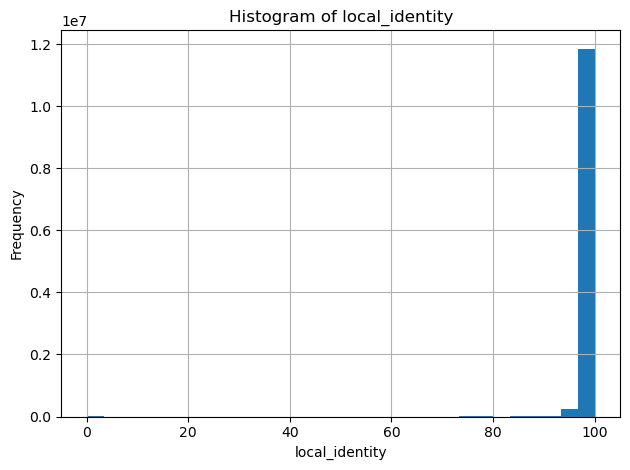

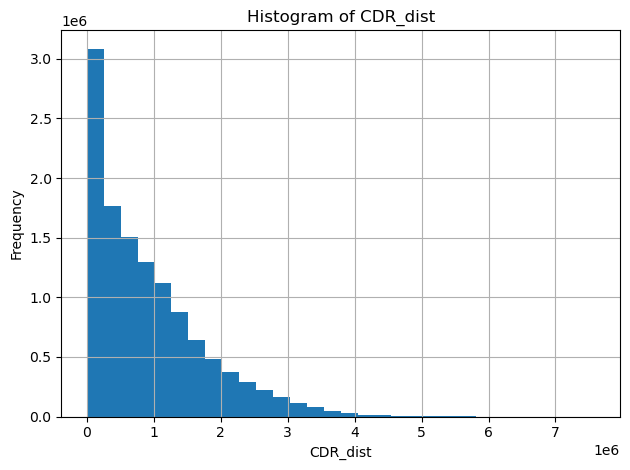

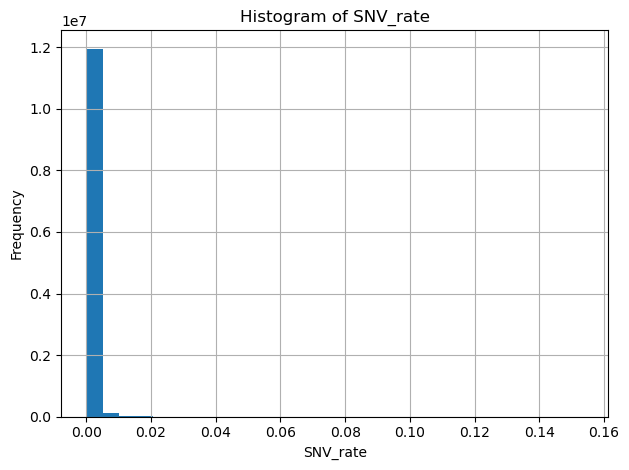

In [10]:
import matplotlib.pyplot as plt

cols = ["local_identity", "CDR_dist", "SNV_rate"]

for col in cols:
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [8]:
## Drop rows with outliers in local identity and SNV rate 
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

df_clean = df.copy()

for col in ["SNV_rate", "local_identity"]:
    lo, hi = iqr_bounds(df_clean[col])
    df_clean = df_clean[df_clean[col].between(lo, hi)]

In [9]:
import statsmodels.api as sm
import pandas as pd

# Make sure df_clean is used
df_clean = df_clean.rename(columns={"chr": "label_chrom"})

# Identify chromosome indicator columns
chr_cols = [c for c in df_clean.columns if c.startswith("chr")]

# Reference chromosome to drop from main effects
chr_ref = "chr1"

# Separate main effect predictors from reference
chr_main_effects = [c for c in chr_cols if c != chr_ref]

# Prepare predictors
X = df_clean[["local_identity", "CDR_dist"] + chr_main_effects].copy()

# Ensure numeric
X["CDR_dist"] = pd.to_numeric(X["CDR_dist"], errors="coerce")
X[chr_main_effects] = X[chr_main_effects].astype(float)

# Create interaction terms for ALL chromosomes INCLUDING reference
for c in chr_cols:
    X[f"CDR_dist_x_{c}"] = X["CDR_dist"] * df_clean[c]

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(df_clean["SNV_rate"], X, missing="drop").fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               SNV_rate   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:13:21   Log-Likelihood:             7.2844e+07
No. Observations:            11029474   AIC:                        -1.457e+08
Df Residuals:                11029425   BIC:                        -1.457e+08
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0075   1.89e-05  

In [10]:
import pandas as pd

# Get model summary as DataFrame
results_df = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t_value": model.tvalues,
    "p_value": model.pvalues,
    "CI_lower": model.conf_int()[0],
    "CI_upper": model.conf_int()[1]
})

# Optional: reset index
results_df = results_df.reset_index().rename(columns={"index": "predictor"})

# View first rows
print(results_df.head())

def format_sci_if_small(x, threshold=0.0001, precision=6):
    if pd.isna(x):
        return ""
    if abs(x) < threshold and x != 0:
        return f"{x:.{precision}e}"  # scientific notation
    else:
        return f"{x:.6f}"  # regular decimal

# Columns to format
numeric_cols = ["coef", "std_err", "t_value", "p_value", "CI_lower", "CI_upper"]

# Apply formatting
formatted_df = results_df.copy()
for col in numeric_cols:
    formatted_df[col] = formatted_df[col].apply(format_sci_if_small)

results_df.to_csv("/private/groups/patenlab/mira/ols_results_full.csv", index=False)

        predictor          coef       std_err     t_value       p_value  \
0           const  7.515283e-03  1.892446e-05  397.120160  0.000000e+00   
1  local_identity -7.297261e-05  1.913213e-07 -381.413863  0.000000e+00   
2        CDR_dist  6.366709e-11  7.466569e-12    8.526954  1.502706e-17   
3            chr2  4.693848e-05  7.001546e-07   67.040159  0.000000e+00   
4            chr3 -1.148897e-04  1.381573e-06  -83.158635  0.000000e+00   

       CI_lower      CI_upper  
0  7.478192e-03  7.552375e-03  
1 -7.334760e-05 -7.259763e-05  
2  4.903288e-11  7.830130e-11  
3  4.556620e-05  4.831076e-05  
4 -1.175976e-04 -1.121819e-04  
